# TD Ecole IMOHTEM : Comment passer d'une image 2D acquise en synchrotron à une courbe de sin2psi

L'objet de ce TD et d'apprendre à passer d'un cliché 2D acquis avec un détecteur type "image plate" (par exemple : MARCCD, pilatus, Eiger...) à une série de diagrammes de diffraction et à réaliser l'analyse de ces derniers.

### Description de l'expérience

Un échantillon de zirconium revêtu avec une couche de chrome de 2 µm d'épaisseur a été analysés lors d'une expérience de Diffraction des Rayons X (XRD) en mode réflexion, réalisée sur la ligne de lumière DiffAbs du synchrotron SOLEIL (France). Pendant l'expériences, des clichés de diffraction 2D ont été collectés à l'aide d'une détecteur image plate MAR CCD 165, qui nous permettront, une fois corrigés et intégrés de remonter aux valeurs de déformation et de contrainte présentes dans la couche de chrome.


### Objectifs
1) Réaliser la calibration du détecteur en utilisant l'outil pyFAI.

2) Effectuer une réduction des données brutes des images 2D aux courbes d'intensité 1D (à l'aide de pyFAI).

3) Réalisez un ajustement de pic unique (à l'aide du package lmfit) du profil Pseudo-Voigt

4) Calculez la déformation et la contrainte à partir des résultats d'ajustement (en supposant qu'aucune contrainte de cisaillement n'est présente).

Le premier objectif n’est pas d’apprendre le codage Python, et cela ne servirait à rien de rester bloqué à cause d’une syntaxe Python inconnue. Par conséquent, j'ai essayé d'abord de présenter chaque fonctionnalité de Python par un exemple avant de vous demander d'écrire votre propre code, afin que vous puissiez copier/coller/modifier et enrichir les sections précédentes du code, sans être bloqué. Dans tous les cas, vous pouvez toujours consulter la correction en tant que notebook Jupyter dans le même répertoire que le notebook actuel.

Les sections où il manque du code, que vous devrez remplir vous-même, sont indiquées par :

<b>##### --- A COMPLETER --- ##### </b>


# Packages
Dans un premier temps, on importe les packages python dont on aura besoin pour l'analyse

pour l'installation d'un package manquant : utiliser la ligne de commande <b> pip install </b> dans un terminal/invité de commande

In [3]:
%matplotlib ipympl
# The function of the previous line is to allow dynamic view of the plots (with zoom-in, zoom-out etc.)

# Some base functionalities of python can be loaded through these two packages
import os 
import re

# Pathlib enale to generate path valid for both Windows and Unix systems
#    https://docs.python.org/3/library/pathlib.html
from pathlib import Path

# Numpy is a package containing several mathematic useful function, 
# the value of pi, etc. as we will use it several time we will call it "np" for short
import numpy as np

# Load various scientific-related function (such as linear regression ...)
from scipy import stats

# Fabio is a package allowing us to read and write .edf images
import fabio

# Pandas can manage tables and databases, we will use it only to load tables stored as .txt or .csv
import pandas as pd

# lmfit is a fitting function package, we will use it to fit Pseudo-Voigt profile to our experimental data
import lmfit

# Matplotlib is a well-known plotting package
from matplotlib import pyplot as plt
from matplotlib import cm # Will be use for generating a colormap

# pyFAI is the package we will use for the calibration of the 
# detector geometry and the data reduction (azimuthal integration)
import pyFAI

import requests

# Fonctions

Il peut être pratique de créer quelques fonctions que vous pourrez utiliser dans le reste de votre code, dans notre cas nous définirons une fonction simple pour convertir l'énergie en longueur d'onde.

N'hésitez pas à ajouter vous-même toutes les fonctions qui pourraient vous être utiles.

In [11]:
def get_wavelenght(E):
    # Energy should be in keV !!!
    # Return the wavelenght in m
    # -----------------------------------
    # Plank Constant
    h = 6.62607004e-34 # m2 . kg / s
    # light celerity
    c = 299792458 # m / s
    # Joule -> eV
    eV = 6.242e+18 # eV / J
    
    # Conversion Energy -> wavelenght 
    wavelenght = ((h*c)/(E*1e3 / eV))  # m
    
    return wavelenght

# Calibration avec une poudre ZnO Nist

Afin d'effectuer la réduction des données (de l'image du détecteur au diffractogramme 1D), nous devons définir la géométrie du détecteur dans le dispositif expérimental.

Pour définir la géométrie du détecteur dans l'espace 3D, il faut savoir :

1) La <b>distance</b> entre l'échantillon et le détecteur

2) La <b>position du faisceau direct</b> sur le détecteur, définie par $(poni_1, poni_2)$ coordonnée (le faisceau direct est réfléchi par l'échantillon dans cette étude)

3) La <b>rotation du détecteur </b> par rapport au faisceau direct, défini par 3 angles de rotation $(rot_1, rot_2, rot_3)$ 

Comme affiché sur ces schémas :

<img src="../Illustrations/PONI1.png" style="width:600px;">
<i>from: https://pyfai.readthedocs.io/en/master/geometry.html</i>
<img src="../Illustrations/PONI2.png" style="width:300px;">

---------

<br>

Nous voulons maintenant ouvrir l'interface graphique de pyFAI :

Les "guidelines" pour utiliser l'interface graphique d'étalonnage pyFAI peuvent être trouvées ici (avec un didacticiel vidéo):</br>
https://pyfai.readthedocs.io/en/master/usage/cookbook/calib-gui/index.html#cookbook-calibration-gui

In [ ]:
os.system("pyFAI-calib2")

# Réduction des données

Il est maintenant temps d'effectuer l'intégration azimutale. Nous commencerons par l'intégration d'une image .edf du détecteur à l'aide de pyFAI.

Tout d'abord, il faut charger la géométrie expérimentale que nous avons définie précédemment (fichier .poni), ainsi que l'image du masque (.edf) :

In [16]:
# Define the raw URL
raw_url = 'https://raw.githubusercontent.com/rguillou91/R_Guillou_TD_DRX/main/utilities/test_calib.poni'
calib_filename = 'test_calib.poni'

# Download the file
response = requests.get(raw_url)
if response.status_code == 200:
    with open(calib_filename, 'wb') as f:
        f.write(response.content)
    print(f"File downloaded successfully: {calib_filename}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

# Let's load the .poni first (ai stand for azimuthal integration)
ai = pyFAI.load(calib_filename)

print(f"Geometry loaded ({calib_filename})")
print('----------')
print(ai)
print('----------')

# Define the raw URL for the EDF file
mask_url = 'https://raw.githubusercontent.com/rguillou91/R_Guillou_TD_DRX/main/utilities/detector_mask.edf'
Mask_filename = 'detector_mask.edf'

# Download the mask file
response = requests.get(mask_url)
if response.status_code == 200:
    with open(Mask_filename, 'wb') as f:
        f.write(response.content)
    print(f"File downloaded successfully: {Mask_filename}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

# Check the size of the downloaded file
print(f"Downloaded file size: {os.path.getsize(Mask_filename)} bytes")

# Load the mask using the fabio package
try:
    mask = fabio.open(Mask_filename) 
    # Extract the data from the mask
    mask_data = mask.data
    print(f"Using {Mask_filename} as mask file")
except Exception as e:
    print(f"Failed to load mask: {e}")

Geometry loaded (/Users/raphie/Documents/Work/TD DRX Ecole IMOHTEM/Sujet TD DRX/Partie 2 DRX synchrotron/utilities/test_calib.poni)
----------
Detector Rayonix SX165	 PixelSize= 7.900e-05, 7.900e-05 m	 BottomRight (3)
Wavelength= 7.044557e-11 m
SampleDetDist= 5.953240e-01 m	PONI= 1.808673e-01, 1.921557e-01 m	rot1=-0.001282  rot2=-0.005199  rot3=0.000000 rad
DirectBeamDist= 595.333 mm	Center: x=2442.011, y=2250.280 pix	Tilt= 0.307° tiltPlanRotation= -76.149° 𝛌= 0.704Å
----------
Using  /Users/raphie/Documents/Work/TD DRX Ecole IMOHTEM/Sujet TD DRX/Partie 2 DRX synchrotron/utilities/detector_mask.edf  as mask file


Nous devons maintenant définir les paramètres de l'intégration azimutale, à savoir :
- $N_{pts}$ : le nombre de points d'intégration (nombre de points sur la courbe 1D)
- $\delta_{rng}$ : la plage d'angle azimutal à inclure dans l'intégration
- $r_{rng}$ : la plage radiale à inclure dans l'intégration
- L'unité dans laquelle nous voulons l'axe des x de la courbe 1D, ainsi que le $\delta_{rng}$ and $r_{rng}$ ($2\theta$ en degré/radian, vecteur de diffusion dans $nm^{-1}$ ...)

<br>
<br>

<img src="../Illustrations/Scheme_ai_crop.png" width=500>


<br>

Les détails de la fontion `.integrate1d()` de pyFAI peuvent être trouvés ici : https://pyfai.readthedocs.io/en/master/api/pyFAI.html#module-pyFAI.azimuthalIntegrator

-----------

<br>

Dans un premier temps, nous ne définirons pas les domaines radials ou azimutals. De cette façon, pyFAI intégrera sur l'ensemble du détecteur, ce qui nous permettra de configurer facilement les plages en regardant la courbe intégrée.

--

Pour le nombre de points d'intégration, nous partirons de 2 000 points arbitrairement (nous l'affinerons plus tard).

--

Il faut aussi charger l'image à intégrer avec python (de la même manière que l'image masque, avec fabio).

> TIP: La syntaxe `"abc" + "def"` apermettre de concaténer des caractères entre eux, de sorte que `"abc" + "def" = "abcdef"` 

In [19]:
def integ_azm(IMG, Scan_path,
              save_folder, Save_pyFAI,
              N_pts, r_rng, azm_sections,
              method_pyFAI = 'cython', integ_unit = '2th_deg'):
    
    # method_pyFAI = 'cython' --> parallel computing (on the pixel treatment)
    # method_pyFAI = 'csr'    --> sequencial computing
    # Most software work with 2theta so I keep it this way... 
    

    # Paths...
    fileName = Scan_path.stem


    #  Azimuthal integration    
    if azm_sections == 1:
        # If there is only one azimuthal section, we use integrate1d()
        res = ai.integrate1d(IMG,
                             npt = N_pts,
                             unit = integ_unit,
                             mask=mask_data, # (1 for masked pixels, and 0 for valid pixels)
                             radial_range = r_rng,
                             method = method_pyFAI,
                             correctSolidAngle = True,
                             filename = save_path)

    elif azm_sections > 1:
        # Else, if there are several azimuthal section, we use integrate2d()
        res = ai.integrate2d(IMG,
                             npt_rad = N_pts,
                             unit = integ_unit,
                             mask = mask, # (1 for masked pixels, and 0 for valid pixels)
                             radial_range = r_rng,
                             npt_azim = azm_sections,
                             method = method_pyFAI,
                             correctSolidAngle = True,
                             filename = save_path)
    
    # Probably return more will be useful
    return (res.radial, res.intensity)


print("***********************")
print("Integraton function defined")
print("------------------------")

***********************
Integraton function defined
------------------------


In [21]:
# Number of integration points
N_pts = 2000

# Define the raw URL for the EDF file
raw_url = 'https://raw.githubusercontent.com/rguillou91/R_Guillou_TD_DRX/main/raw_images/CR1bnonirr_0.edf'
ech_filename = 'CR1bnonirr_0.edf'  # Ensure the correct file extension

# Download the file
response = requests.get(raw_url)
if response.status_code == 200:
    with open(ech_filename, 'wb') as f:
        f.write(response.content)
    print(f"File downloaded successfully: {ech_filename}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

# Load the image using the fabio package
try:
    path_IMG = Path(ech_filename)  # Using the current directory
    IMG = fabio.open(path_IMG)
    IMG_data = IMG.data  # Extract the data from the image
    print(f"Image loaded successfully: {path_IMG}")
except Exception as e:
    print(f"Failed to load image: {e}")

# Define azimuthal integration setup
ai = pyFAI.AzimuthalIntegrator()  # Create an instance of AzimuthalIntegrator

# Assuming you have a mask defined; replace this with your actual mask
mask = np.zeros_like(IMG_data, dtype=int)  # Example: no masked pixels

# Define save path for the integration result
path_int = Path("output_directory/integrated")  # Base directory for saving the file

# Create the directory (but only the directory path, not the file name)
path_int.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

# Now define the full save path, including the filename
ech_filename = "CR1bnonirr_0.edf"  # Example filename
save_path = path_int / (ech_filename.replace('.edf', '.dat'))  # Save as .dat file

# Now you can proceed to save your file at 'save_path'
print(save_path)  # This will output the correct path to save the file

# Azimuthal integration
print(f"Integrating {path_IMG} ...")
try:
    res = ai.integrate1d(
        IMG_data,
        npt=N_pts,
        unit="2th_deg",  # Using 2 theta in degrees
        mask=mask_data,  # Using the mask defined earlier
        filename=str(save_path)
    )
    print(f"Integration results saved at: {save_path}")
except Exception as e:
    print(f"Failed to perform azimuthal integration: {e}")



Integrating //Users/raphie/Documents/Work/TD DRX Ecole IMOHTEM/Correction TD DRX/Partie 2 DRX synchrotron/raw_images/CR1bnonirr_0.edf ...


saved at  //Users/raphie/Documents/Work/TD DRX Ecole IMOHTEM/Correction TD DRX/Partie 2 DRX synchrotron/integrated/CR1bnonirr_0.dat


> NB: Si vous le souhaitez, vous pouvez afficher l'image en utilisant :
> ```python
> fig = plt.figure()
> plt.imshow(IMG, cmap='jet')
> plt.clim(0, 200)
> plt.show()
> ```


`res` contiennent plusieurs informations, en particulier, les valeurs d'intensité sont enregistrées dans `res.intensity` et les valeurs $2\theta$ sont enregistrées dans `res.radial`. Pour rendre les choses plus simples, nous allons les enregistrer dans des variables séparées et tracer le diffractogramme.

> TIP: Voici le minimum que vous devez écrire pour créer un tracé avec le package matplotlib :
> ```python
> X = [1,2,3,4]
> Y = [5,5,8,2]
> 
> fig = plt.figure()
> plt.plot(X, Y)
> fig.show()
> ```

# Visualisation du diagramme de diffraction sur une intégration moyenne

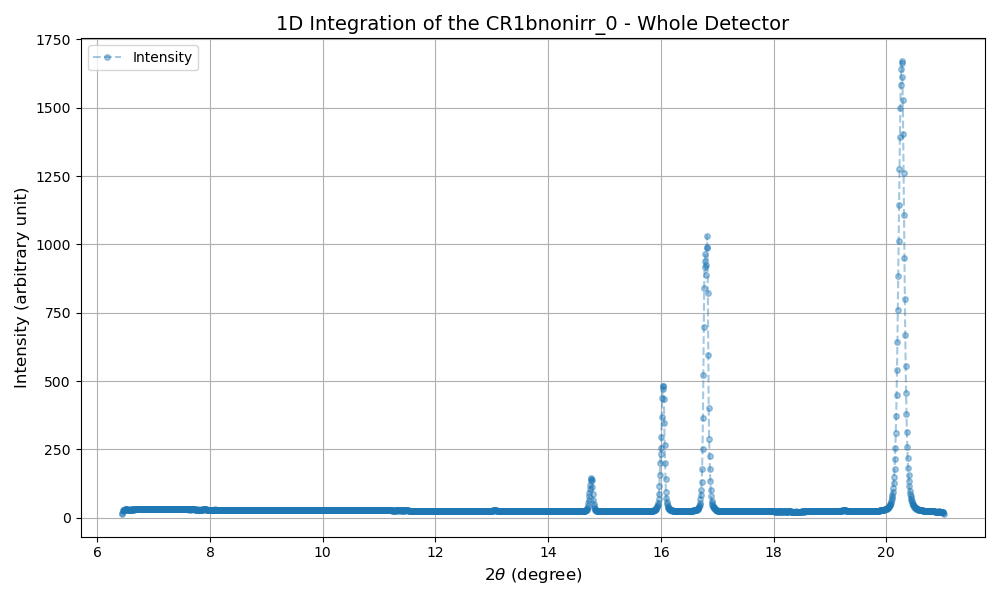

In [26]:
Tth = res.radial  # deg
I = res.intensity

plt.figure(figsize=(10, 6))  # Optional: Specify figure size
plt.plot(Tth, I, marker="o", linestyle="--", alpha=0.4, markersize=4, label='Intensity')
plt.yscale("linear")
plt.xlabel(r"$2\theta$ (degree)", fontsize=12)
plt.ylabel("Intensity (arbitrary unit)", fontsize=12)
plt.title(f"1D Integration of the {fileName} - Whole Detector", fontsize=14)
plt.legend()
plt.grid(True)  # Optional: Add a grid for better readability
plt.tight_layout()  # Adjust layout to prevent clipping

plt.show()

> NB: Par défaut, `.integrate1d()` corrige l'intensité depuis l'angle solide pour chaque pixel du détecteur.

Le chrome (BCC) doit avoir un pic de diffraction visible à cette énergie tandis que le zirconium (HCP) doit en avoir 3 :

<b> Cr</b>
- [1 1 0]: $\approx$ ??

<b> ZR</b>

- [1 0. 0]: $\approx$ 14.46° (plan prismatique)
- [0 0. 2]: $\approx$ 15.74° (plan basal)
- [1 1. 0]: $\approx$ 16.47° (plan pyramidal)

> Les diagrammes de poudre peuvent être calculés à partir de fichiers cristallographiques .cif (de COD par exemple http://www.cristallography.net/cod/) par des logiciels gratuits comme: 
>- Mercury (https://www.ccdc.cam.ac.uk/solutions/csd-core/components/mercury/)
>- ReciprOgraph (https://www.epfl.ch/schools/sb/research/iphys/teaching/crystallography/reciprograph/)
>- ...

------

En zoomant sur le graphique vous pouvez définir le $r_{rng}$ à appliquer à l'intégration pour avoir les <b>4 pics incluant la base du pic</b>.

-- 

Pour pouvoir extraire la contrainte/déformation, nous devrons effectuer plusieurs intégrations avec un <b>pas azimutal que nous fixerons à 5°</b>. 
Ce pas azimutal doit produire des courbes pas trop bruitées et est raisonnablement petit (vous pouvez le déterminer par essais et tracé comme pour le $r_{rng}$ précédemment réglé)

-- 

Afin de déterminer le nombre de points d'intégration $N_{pts}$, il peut être plus significatif de calculer la taille des étapes d'intégration en pixel, pour ce faire, calculez `Dtheta_pix`, la taille d'un pixel en termes de 2 $ \theta$ (deg), en utilisant la relation (et le package numpy) :

$$
tan(2\theta) = \frac{Pixel_{size}}{D}
$$

> TIP: Vous aurez besoin de la fonction `np.arctan()` (en utilisant l'angle en radian).

Et en déduire la valeur de `N_pts` pour intégrer <b>1 pixel/point</b>, connaissant la plage radiale `r_rng`

> NB: On aurait pu choisir moins de 1 pixel/point

> <b>TIP:</b> Afin d'intégrer toutes les courbes, nous devrons exécuter plusieurs fois la fonction `ai.integrated1D()` de pyFAI. Pour être efficace, nous allons le mettre dans une boucle for, voici la syntaxe pour y parvenir
>
> Exemple with a dummy `for:` loop:
> ```python
> for ii in range(0,10):
>     print(ii)
> print("The loop is over now")
> ```
> 
> Voici comment faire la boucle avec la fonction `ai.integrate1D()`:
> ```python
> # Nous allons effectuer une boucle sur toute la plage azimutale que nous souhaitons intégrer
> for ii in range(0, N_delta): # This mean the followed indented instruction will repeat with increasing value of "ii" varying between 0 and N_delta(=16)
>     delta_rng = [delta_bounds[0] + (ii * delta_step), delta_bounds[0] + ((ii+1) * delta_step)]
> 
>     # Pour mémoriser la plage azimutale de toute l'intégration, j'utilise la première limite de la plage azimutale dans le nom du fichier enregistré
>     save_path = Path(path_int, fileName + "_" + str(delta_rng [0]) + ".dat") # str() allow to transform a number (float, integer ...) into a string
> 
>     res = ai.integrate1d(IMG,
>                          npt = N_pts, # Number of integration points
>                          unit = "2th_deg", # We want to use 2 theta in degree 
>                          mask = mask, # previously loaded (1 for masked pixels, and 0 for valid pixels is the pyFAI standard)
>                          azimuth_range = delta_rng, # the range of the azimuthal angle (define at the begining of each loop)
>                          radial_range = r_rng, # the radial range
>                          filename = save_path) # The name of the file to save the data
>     
>     print(f"saved at  {save_path}")
```

# Intégration par secteur

In [ ]:
# Radial range
# ------
r_rng = [19.5, 21] # deg

# Azimuthal step
# ------
delta_step = 2 # deg
# There is no need to go from 0 to 360° as the detector do not cover
# the whole diffraction ring (measurement was in reflection).
# We will then integrate within these bounds:
delta_bounds = [210, 232]
# And then we will have N_delta steps:
N_delta = int(np.abs((delta_bounds[1] - delta_bounds[0]) / delta_step))

# Determination of the number of integration points
# ----------
pix_per_pts = 1

pix_size = ai.pixel1 # pixel size of the detector (m)
D = ai.dist # Distance between the sample and the detecor (m)
r_lenght = r_rng[1] - r_rng[0] # deg

Dtheta_pix = np.arctan(pix_size/D) * (180/np.pi) # size of a pixel in terms of 2theta (deg)
N_pts = int(r_lenght/(pix_per_pts * Dtheta_pix))

# Loading the image file of the sample 
# ---------

ech_filename = 'CR1bnonirr_0.edf'
try:
    path_IMG = Path(ech_filename)  # Using the current directory
    IMG = fabio.open(path_IMG)
    IMG_data = IMG.data  # Extract the data from the image
    print(f"Image loaded successfully: {path_IMG}")
except Exception as e:
    print(f"Failed to load image: {e}")


#  Azimuthal integration
# --------
print(f"Integrating {path_IMG}   (N_pts = " + str(N_pts) + ") ...")
# This time we will perform a loop over the whole azimuthal range we want to integrate
for ii in range(0, N_delta):
    delta_rng = [delta_bounds[0] + (ii * delta_step), delta_bounds[0] + ((ii+1) * delta_step)]

    # To remember the azimuthal range of all the integration
    # I use the first bound of the azimuthal range in the saved file name
    # We need to remember that delta_step = 10 deg
    save_path = Path(path_int, ech_filename.replace('.edf', '') + f"_{delta_rng[0]:.1f}.dat")

    res = ai.integrate1d(IMG,
                         npt = N_pts,
                         unit = "2th_deg", # We want to use 2 theta in degree 
                         mask = mask, # (1 for masked pixels, and 0 for valid pixels is the pyFAI standard)
                         azimuth_range = delta_rng,
                         radial_range = r_rng,
                         filename = str(save_path))
    
    print(f"saved at  {save_path}")

# Visualisation d'un diagramme de diffraction pour un secteur d'intégration

Nous pouvons lire et vérifier les fichiers intégrés comme celui-ci (en utilisant le package pandas):

In [ ]:
delta_start = 228
path_file = Path(path_int, ech_fileName + "_" + str(delta_start) + ".dat")
DATA = pd.read_csv(path_file, skiprows=22, delimiter = " ", skipinitialspace = True)

Tth_raw = DATA.values[:,0] # deg
I_raw = DATA.values[:,1]

fig = plt.figure()
plt.plot(Tth_raw, I_raw, marker="o", linestyle="none", alpha=0.4, markersize=4)
plt.yscale("linear")
plt.xlabel(r"$2\theta$ (degree)")
plt.ylabel("Intensity (arbitraty unit)")
#fig.show()

Pour cet exercice, nous nous concentrerons uniquement sur le pic de diffraction [1 1 0] du Cr. Ensuite, vous pouvez définir un `Tth_rng` pour recadrer les données intégrées.

In [ ]:
# Define a range of 2theta to crop the data arround the [1 1 0]
Tth_rng = [19.8, 20.5]

crop = (Tth_raw > Tth_rng[0]) & (Tth_raw < Tth_rng[1])
Tth = Tth_raw[crop]
I = I_raw[crop]

# Plot the croped [110] peak
fig = plt.figure()
plt.plot(Tth, I, marker="o", linestyle="none", alpha=0.4, markersize=4)
plt.yscale("linear")
plt.xlabel(r"$2\theta$ (degree)")
plt.ylabel("Intensity (arbitraty unit)")
#fig.show()

# Superposition de tous les diagrammes de diffraction des différents secteurs d'intégration

#### Chargement de l'ensemble des données

L'idée est maintenant de charger l'ensemble des données dans 2 variables :
- Tth les 2 valeurs thêta
- Je l'intensité

Tth - sera un tableau à 1 dimension (1 colonne) représentant les valeurs de 2thêta de l'intensité

I - sera un tableau à 2 dimensions, où chaque colonne représentera une plage azimutale, suivant ce schéma :

<br>

$$
Tth = \begin{pmatrix}
2\theta_1 \\
2\theta_2 \\
\vdots    \\
2\theta_{final}
\end{pmatrix}
$$

<br>
<br>

$$
I = \begin{pmatrix}
I(2\theta_1, \delta_{rng} = [160, 170]) & I(2\theta_1, \delta_{rng} = [170, 180]) & ... & I(2\theta_1, \delta_{rng} = [230, 240])  \\
I(2\theta_2, \delta_{rng} = [160, 170]) & I(2\theta_2, \delta_{rng} = [170, 180]) & ... & I(2\theta_2, \delta_{rng} = [230, 240])  \\
\vdots & \vdots & \ddots & \vdots                    \\
I(2\theta_{final}, \delta_{rng} = [160, 170]) & I(2\theta_{final}, \delta_{rng} = [170, 180]) & ... & I(2\theta_{final}, \delta_{rng} = [230, 240])  \\
\end{pmatrix}
$$

-----

`Tth` avait en fait déjà été défini à la dernière étape, il suffit de définir `I` 

In [ ]:
# File to load
ech_filename = 'CR1bnonirr_0.edf'
# Azimuthal angles to load (first bound)
azimuth_toLoad = np.arange(delta_bounds[0], delta_bounds[1], delta_step) # The last value (240) will not be included in the list which will then stop at 230 as we want

# We need to initialize "I" with np.zeros to the correct shape
I = np.zeros((len(Tth), len(azimuth_toLoad)))

# Then load all the file in a for loop 
# and sore them into I (without forgetting to apply the crop)
for ii in range(0, len(azimuth_toLoad)):
    path_file = Path(path_int, fileName + "_" + str(azimuth_toLoad[ii]) + ".dat")
    print(f"loading {path_file}   ...")
    DATA = pd.read_csv(path_file, skiprows=22, delimiter = " ", skipinitialspace = True)
    
    I[:,ii] = DATA.values[crop,1]

print("All done!")

# We can also print them all now, in a for loop again:
cmap = cm.get_cmap('jet', len(azimuth_toLoad))

fig = plt.figure()
for ii in range(0, azimuth_toLoad.shape[0]):
    plt.plot(Tth, I[:,ii], marker="o", linestyle="-", alpha=0.4, markersize=4, \
             color=cmap(ii), label=f"[{azimuth_toLoad[ii]},{azimuth_toLoad[ii]+delta_step}]°")
plt.yscale("log")
plt.xlabel(r"$2\theta$ (degree)")
plt.ylabel("Intensity (arbitraty unit)")
plt.legend()
#fig.show()

# Ajustement des pics de diffractions avec une pseudo Voigt

Maintenant que toutes les réductions de données sont terminées, nous devrons trouver la position maximale pour chaque `delta_rng`. Afin d'obtenir ces positions maximales, nous ajusterons les données expérimentales à un modèle Pseudo-Voigt (vous pouvez également utiliser un modèle Pearson7, ou un modèle Voigt si vous préférez). 

Nous utiliserons le package lmfit pour le faire (https://lmfit.github.io/lmfit-py/builtin_models.html#pseudovoigtmodel).

------

Dans le package lmfit, le modèle pseudo-voigt est intégré (ainsi que Pearson7 et Voigt), utilisons-le donc :

In [ ]:
# We will call this model "peak_model" 
peak_model = lmfit.models.PseudoVoigtModel(prefix='peak_')

Par défaut ce modèle possède 4 paramètres indépendants 
- `amplitude` : L'amplitude du Pseudo-Voigt 
- `center` : Le centre du Pseudo-Voigt 
- `fraction` : La fraction de contribution lorentzienne et gaussienne du Pseudo-Voigt 
- `sigma` : La dispersion du Pseudo-Voigt 

2 autres paramètres (« hauteur » et « fwhm » pleine largeur demi-maximum) sont introduits dans le modèle, mais sont en fait calculés à partir de la valeur de « amplitude » et « sigma » respectivement.

Les détails sur la façon dont le modèle est défini peuvent être trouvés dans : https://lmfit.github.io/lmfit-py/builtin_models.html#pseudovoigtmodel

-----

Nous devrons les initialiser à une valeur qui sera utilisée comme estimation initiale pour l'algorithme d'ajustement des moindres carrés effectué par la suite.

In [ ]:
# This define the parameter list as defined by the "PseudoVoigtModel" of lmfit
pars = peak_model.make_params()
pars['peak_amplitude'].set(value=20, min=0, max=1e6)
pars['peak_center'].set(value=20.3,  min=0, max=50)
pars['peak_fraction'].set(value=0.5, min=0, max=1) # (Some papers allow the fraction to be higher than 1)
pars['peak_sigma'].set(value=0.1,    min=0, max=10) 

# We can check the values of the parameters and their boundaries with:
pars.pretty_print(oneline=False, colwidth=12, columns=['value', 'min', 'max'])

Nous pouvons ensuite calculer les valeurs du modèle aux valeurs Tth et tracer la supposition initiale avec les données expérimentales :

In [ ]:
# This compute the intensity with the given model and parameters, at x = Tth (our 2theta values)
I_calc_init = peak_model.eval(pars, x=Tth)

# Plot
cmap = cm.get_cmap('jet', len(azimuth_toLoad))

fig = plt.figure()
ii = 0 # We will sart with ii = 0 (delta = [160, 170])
plt.plot(Tth, I[:,ii], marker="o", linestyle="none", alpha=0.4, markersize=4, \
         color=cmap(ii), label=f"Exp. data [{azimuth_toLoad[ii]},{azimuth_toLoad[ii]+delta_step}]°")

plt.plot(Tth, I_calc_init, '-', color = [40/255, 190/255, 70/255], label = "Initial guess")

plt.yscale("linear")
plt.xlabel(r"$2\theta$ (degree)")
plt.ylabel("Intensity (arbitraty unit)")
plt.title("Intial guess - model with only a Pseudo-Voigt profile")
plt.legend()
#fig.show()

------------

Pour avoir un bon ajustement des données expérimentales, il devient évident que nous devrons également modéliser l’arrière-plan. 

Il existe de nombreux modèles de fond qui pourraient être adaptés, je propose d'utiliser simplement un fond polynomial d'ordre 2 :

In [ ]:
# This is not a build-in function of lmfit (at my knowledge), so we need to define it first:
def background(x, y0, y1, y2):
    return(y0 + y1 * x + y2 * x**2)
# I called the three parameters of this functions "y_0", "y_1" and "y_2" 

# We now define it as a lmfit model:
bkg = lmfit.Model(background)

# In order to fit at the same time the background and the peak, we need to concatenate the two models:
model = bkg + peak_model

# This time we will update the parameters "pars" with the parameters of the background
# (if we had generated the parameters using .make_params(), the Pseudo-Voigt peak parameters would have been removed)
pars.update(bkg.make_params())
pars['y0'].set(value = 62,   min = 1e-08, max = 1000)
pars['y1'].set(value = 1e-3, min = 1e-08, max = 100)
pars['y2'].set(value = 1e-3, min = 1e-08, max = 10)

I_calc_init = model.eval(pars, x=Tth)

# Plot
cmap = cm.get_cmap('jet', azimuth_toLoad.shape[0])

fig = plt.figure()
ii = 0 # We will sart with ii = 0 (delta = [160, 170])
plt.plot(Tth, I[:,ii], marker="o", linestyle="none", alpha=0.4, markersize=4, \
         color=cmap(ii), label=f"Exp. data [{azimuth_toLoad[ii]},{azimuth_toLoad[ii]+delta_step}]°")

plt.plot(Tth, I_calc_init, '-', color = [40/255, 190/255, 70/255], label = "Initial guess")

plt.yscale("linear")
plt.xlabel(r"$2\theta$ (degree)")
plt.ylabel("Intensity (arbitraty unit)")
plt.title("Intial guess - model with a Pseudo-Voigt profile + polynomial Background")
plt.legend()
#fig.show()

-----------

Il est maintenant temps d’effectuer l’ajustement par les moindres carrés !

In [ ]:
ii = 0  # We will sart with ii = 0 (delta = [160, 170])

# The intensity value to be fitted need to be selected, we will store them into a variable "yy"
yy = I[:,ii]

# A common practice for XRD peak fitting is to weight the fit by the 1/I or the square root of 1/I.
# This way, the fit will not accord too much importance to the high values of the diffraction pattern. 
# (We should however be careful that none of the yy values are equal to 0...)
wgt = np.sqrt(1/yy)

# Fitting
out = model.fit(yy, pars, x=Tth, weights=wgt) #fitting

# The fitted intensity can be found with:
I_fit = out.best_fit

# To evaluate the goodness of the fit, the value of Rwp is often used (again, the smaller Rwp the better)
# Here is the formula to calculate it:
Rwp  = (np.sqrt(np.sum(wgt*(yy-out.best_fit)**2) / np.sum(wgt*yy**2))) * 100;


# Plot - I propose this type of plots, allowing to see the residuals (I_experiment - I_fitted)
cmap = cm.get_cmap('jet', azimuth_toLoad.shape[0])

fig = plt.figure()
grid = fig.add_gridspec(4, 1, hspace=0)

ax1 = plt.subplot(grid[0:3, 0])
plt.plot(Tth, I[:,ii], marker="o", linestyle="none", alpha=0.4, markersize=4,\
         color=cmap(ii), label=f"[{azimuth_toLoad[ii]},{azimuth_toLoad[ii]+delta_step}]°")
plt.plot(Tth, I_fit, '-', color = [240/255, 70/255, 40/255], linewidth=1.2, label = "Fit")
plt.plot(Tth, background(Tth, out.best_values["y0"], out.best_values["y1"], out.best_values["y2"]), '-', color = [130/255, 130/255, 130/255], linewidth=1.2, label = "Background")

plt.yscale("linear")
plt.xlabel(r"$2\theta$ (degree)")
plt.ylabel("Intensity (arbitraty unit)")
plt.title(f"[111] peak fit (Rwp = {np.round(Rwp*100)/100} %)")
plt.legend()

ax2 = plt.subplot(grid[3, 0], sharex=ax1)
plt.plot(Tth, yy - I_fit, 'o', markersize = 1.5, alpha = 0.6,\
         color = [30/255, 30/255, 30/255], label = "residuals")
plt.legend(loc='best')
plt.xlabel(r"$2 theta$ (deg)")
plt.ylabel("Residuals (a.u.)")

#fig.show()

In [ ]:
ii = 0  # We will sart with ii = 0 (delta = [160, 170])

# The intensity value to be fitted need to be selected, we will store them into a variable "yy"
yy = I[:,ii]

# A common practice for XRD peak fitting is to weight the fit by the 1/I or the square root of 1/I.
# This way, the fit will not accord too much importance to the high values of the diffraction pattern. 
# (We should however be careful that none of the yy values are equal to 0...)
wgt = np.sqrt(1/yy)

# Fitting
out = model.fit(yy, pars, x=Tth, weights=wgt) #fitting

# The fitted intensity can be found with:
I_fit = out.best_fit

# To evaluate the goodness of the fit, the value of Rwp is often used (again, the smaller Rwp the better)
# Here is the formula to calculate it:
Rwp  = (np.sqrt(np.sum(wgt*(yy-out.best_fit)**2) / np.sum(wgt*yy**2))) * 100;


# Plot - I propose this type of plots, allowing to see the residuals (I_experiment - I_fitted)
cmap = cm.get_cmap('jet', azimuth_toLoad.shape[0])

fig = plt.figure()
grid = fig.add_gridspec(4, 1, hspace=0)

ax1 = plt.subplot(grid[0:3, 0])
plt.plot(Tth, I[:,ii], marker="o", linestyle="none", alpha=0.4, markersize=4,\
         color=cmap(ii), label=f"[{azimuth_toLoad[ii]},{azimuth_toLoad[ii]+delta_step}]°")
plt.plot(Tth, I_fit, '-', color = [240/255, 70/255, 40/255], linewidth=1.2, label = "Fit")
plt.plot(Tth, background(Tth, out.best_values["y0"], out.best_values["y1"], out.best_values["y2"]), '-', color = [130/255, 130/255, 130/255], linewidth=1.2, label = "Background")

plt.yscale("linear")
plt.xlabel(r"$2\theta$ (degree)")
plt.ylabel("Intensity (arbitraty unit)")
plt.title(f"[111] peak fit (Rwp = {np.round(Rwp*100)/100} %)")
plt.legend()

ax2 = plt.subplot(grid[3, 0], sharex=ax1)
plt.plot(Tth, yy - I_fit, 'o', markersize = 1.5, alpha = 0.6,\
         color = [30/255, 30/255, 30/255], label = "residuals")
plt.legend(loc='best')
plt.xlabel(r"$2 theta$ (deg)")
plt.ylabel("Residuals (a.u.)")

#fig.show()

> Vous pouvez vérifier si l'ajustement semble correct à la fois en échelle linéaire et logarithmique. l'échelle logarithmique augmentera les erreurs à la base du pic mais les minimisera au sommet...

Nous pouvons imprimer le rapport à partir de l'ajustement, avec les valeurs de sortie, les intervalles de confiance et le $\chi^2$ de l'ajustement (plus le $\chi^2$ est bas, meilleur est l'ajustement).

In [ ]:
print(out.fit_report(show_correl=False))

> En regardant la valeur de y1 et y2 et l'intervalle de confiance associé on peut essayer de réduire l'ordre polynomial du fond à 1 voire 0, ce qui augmenterait certainement un peu la stabilité de l'ajustement... Mais ce n'est peut-être pas le cas être le cas pour l'autre delta_rng !

#### Ajustement de tous les delta_rng

Nous devrons faire de manière itérative la même opération sur toutes les courbes pour couvrir tout le delta_rng. Pour l’instant, nous utiliserons la même estimation initiale pour tous les ajustements. 

Pour notre étude, nous n'aurons besoin que de la valeur du centre du pic, mais nous conserverons les 7 paramètres indépendants de notre modèle (4 pour le Pseudo-Voigt, 3 pour le Fond) par sécurité (pour pouvoir recalculer la Pseudo-Voigt plus tard par exemple).

In [ ]:
# At the end of all the refinements there will have azimuth_toLoad.shape[0] (= 8) values:
center = np.zeros(azimuth_toLoad.shape[0])
Amp = np.zeros(azimuth_toLoad.shape[0])
frac = np.zeros(azimuth_toLoad.shape[0])
s = np.zeros(azimuth_toLoad.shape[0])
y0 = np.zeros(azimuth_toLoad.shape[0])
y1 = np.zeros(azimuth_toLoad.shape[0])
y2 =np.zeros(azimuth_toLoad.shape[0])
Rwp =np.zeros(azimuth_toLoad.shape[0])



# Now we can do the itterative fitting of the curves:
for ii in range(0, azimuth_toLoad.shape[0]):
    yy = I[:,ii]
    wgt = np.sqrt(1/yy)

    # Fitting
    out = model.fit(yy, pars, x=Tth, weights=wgt) #fitting
    
    # Store all the results into variables
    center[ii] = out.best_values["peak_center"]
    Amp[ii] = out.best_values["peak_amplitude"]
    frac[ii] = out.best_values["peak_fraction"]
    s[ii] = out.best_values["peak_sigma"]
    y0[ii] = out.best_values["y0"]
    y1[ii] = out.best_values["y1"]
    y2[ii] = out.best_values["y2"]
    Rwp[ii]  = (np.sqrt(np.sum(wgt*(yy-out.best_fit)**2) / np.sum(wgt*yy**2))) * 100;
    
    print(f"chi2 = {out.chisqr}")
    
    # Plot - I propose this type of plots, allowing to see the residuals (I_experiment - I_fitted)
    fig = plt.figure()
    grid = fig.add_gridspec(4, 1, hspace=0)

    ax1 = plt.subplot(grid[0:3, 0])
    plt.plot(Tth, I[:,ii], marker="o", linestyle="none", alpha=0.4, markersize=4,\
             color=cmap(ii), label=f"[{azimuth_toLoad[ii]},{azimuth_toLoad[ii]+delta_step}]°")
    plt.plot(Tth, out.best_fit, '-', color = [240/255, 70/255, 40/255], linewidth=1.2, label = "Fit")
    plt.plot(Tth, background(Tth, out.best_values["y0"], out.best_values["y1"], out.best_values["y2"]), '-', color = [130/255, 130/255, 130/255], linewidth=1.2, label = "Background")

    plt.yscale("linear")
    plt.xlabel(r"$2\theta$ (degree)")
    plt.ylabel("Intensity (arbitraty unit)")
    plt.title(f"[111] peak fit (Rwp = {np.round(Rwp[ii]*100)/100} %)")
    plt.legend()

    ax2 = plt.subplot(grid[3, 0], sharex=ax1)
    plt.plot(Tth, yy - out.best_fit, 'o', markersize = 1.5, alpha = 0.6,\
             color = [30/255, 30/255, 30/255], label = "residuals")
    plt.legend(loc='best')
    plt.xlabel(r"$2 theta$ (deg)")
    plt.ylabel("Residuals (a.u.)")
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    #fig.show()

# Calcul de d(110)

À partir du centre du pic [1 1 0], nous pouvons calculer la distance inter-réticulaire d des plans [1 1 0] en utilisant la formule de Bragg :

$$
2d_{hkl} \ : sin(\theta_{hkl}) = \lambda
$$

Avec $\theta_{hkl}$ le demi-angle de diffraction pour le pic $[h k l]$ de Au et $\lambda$ la longueur d'onde du faisceau de rayons X.

In [ ]:
E = 17.6 # keV
wavelenght = get_wavelenght(E) * 1e10 # Ang

d_110 = (1/2) * wavelenght / np.sin((center/2) * (np.pi/180)) # Ang

# We cna also calculate the center of all the delta_rng
delta_center = azimuth_toLoad + delta_step/2 # deg


fig = plt.figure()
plt.plot(delta_center, d_110, marker="o", linestyle="--", alpha=0.4, markersize=8)
plt.xlabel(r'$\delta$ (deg)')
plt.ylabel(r'$d_{[1 1 0]}$ (Angström)')

# Détermination de la déformation
<a name="8"></a>

Pour la détermination de la déformation nous aurons besoin de :

1) Déterminer le $2\theta$ du pic $[1 1 0]$ non contraint du Cr.

2) Calculer les angles $\Psi$

----

Pour réaliser l’étape 1), le mieux est d’utiliser la valeur expérimentale du revêtement de Cr non contraint. Cependant, nous ne disposons pas de cette donnée (même sans déformation appliquée, les revêtements ont une contrainte résiduelle non négligeable), nous utiliserons donc simplement la valeur de la base de données cristallographique contenue dans `utilities/Cr-5000220.cif`.

Sur ce fichier .cif vous pouvez copier/coller le paramètre de la cellule (`2.884` Ang).

A partir de cette valeur, vous pouvez calculer le d_spacing du plan [110] puis le theta_0 produit par la diffraction du plan [110] non contraint.

Sachant que, pour un système cubique :

$$
a = d_{hkl} \times \sqrt{h^2 + k^2 + l^2}
$$

In [ ]:
a_Cr = 2.884 # Ang

# For a cubic system we have:
d0_110 = a_Cr / np.sqrt(1**2 + 1**2 + 0**2)

theta_0 = np.arcsin(wavelenght / (2*d0_110)) # rad
theta_0 = (180/np.pi)*theta_0 # deg

print(f"theta_0 = {theta_0} °  |  d0_hkl = {d0_110} Ang")

Pour l'expérience, l'angle $\omega$ entre le faisceau et la surface du Cr était $\omega = 4°$.

Et à partir de ces valeurs, nous pouvons calculer l'angle $\Psi$, en utilisant cette formule :

$$
\cos(\Psi) = \sin(\omega)\sin(\theta) + \cos(\omega)\cos(\theta)\cos(\delta)
$$

# Calcul des angles psi

In [ ]:
omega = 4 # deg
delta_center = azimuth_toLoad + delta_step/2 # deg
#delta_center = np.arange(0,360,1) # if you want to see how these angles evolves on the whole azimuth
theta_exp = center/2 # deg

omega_r = omega * (np.pi/180) # rad
theta_0_r = theta_0 * (np.pi/180) # rad
delta_center_r = delta_center * (np.pi/180) # rad
theta_exp_r = theta_exp * (np.pi/180) # rad

cos_psi =  ( np.sin(omega_r) * np.sin(theta_0_r) ) + ( np.cos(omega_r) * np.cos(theta_0_r) * np.cos(delta_center_r) )
psi_r = np.abs(np.arccos(cos_psi))
psi = psi_r * (180/np.pi)

# Then, it will be useful to calculate the sin²(Psi)
sin2_psi = np.sin(psi_r)**2

# We could also calculate phi...
#sin_phi = (( -np.cos(omega_r) * np.sin(theta_0_r) ) + ( np.sin(omega_r) * np.cos(theta_0_r) * np.cos(delta_center_r) )) / np.abs(np.sin(psi_r))
#phi_r = np.abs(np.arcsin(sin_phi))
#phi = phi_r * (180/np.pi)


fig = plt.figure()
plt.plot(delta_center, psi, '.-', color="r", label=r"$\Psi$")
#plt.plot(delta_center, phi, '.-', color="b", label=r"$\phi$")
plt.xlabel(r"azimuthal angle $\delta$ (deg)")
plt.ylabel("$\Psi$ (deg)")
plt.title(r"Evolution of the $\Psi$ angle with the azimuth $\delta$")
plt.legend()
#fig.show()

# Calcul et visualisation de la courbe déformation en fonction de sin2psi

---------


Nous pouvons maintenant calculer la déformation et la tracer en fonction de $\sin^2(\psi)$, comme :

$$
\epsilon = \ln\left(\frac{\mathrm{d}_{[110]}}{\mathrm{d}^0_{[110]}}\right) \approx \frac{\mathrm{d} _{[110]} - \mathrm{d}^0_{[110]}}{\mathrm{d}^0_{[110]}}
$$

In [ ]:
epsilon = np.log(d_110/d0_110) # strain (without unit)

fig = plt.figure()
plt.plot(sin2_psi, epsilon*100, 'o', color="r", linestyle="none", alpha=0.4, markersize=8)
plt.xlabel(r'$\sin^2(\Psi)$')
plt.ylabel(r'$\epsilon_{[1 1 0]}$ (%)')
plt.title("Strain of the [110] plane of Cr")

# Calcul de la contrainte

En supposant que les contraintes de cisaillement sont négligeables, nous pouvons maintenant calculer la contrainte de la contrainte, étant donné le module d'Young et le coefficient de Poisson pour le chrome : E = 280 GPa et v = 0,22 respectivement, car la contrainte devrait alors suivre cette relation :

$$
\sigma_{\Phi} = \frac{E}{(1+\nu) \sin^2(\Psi)} \times \epsilon_{\Phi}
$$

Les contraintes sont supposées planes et équibiaxiales dans la couche de chrome, on peut donc simplifier $\sigma_{11}$ = $\sigma_{22}$ = $\sigma_{r}$
Afin de déterminer $\sigma_{r}$, on peut alors faire une régression linéaire :

In [ ]:
# We will use the package scipy, from wich we load only "stats":
slope, intercept, r_value, _, std_err = stats.linregress(sin2_psi, epsilon)
R2 = r_value**2

# Young modulus
E = 280 # GPa

# Poisson ratio
v = 0.22

# We can then calculate the stress:
sigma = (slope) * E / (1+v)
# We can estimate an error, based on the error on the slope of the linear regerssion
# However, this error do not take into account the uncertaininties of the pseudo-Voigt fit
# and other errror sources that propagate so the erorr is minimized... 
sigma_err = (std_err) * E / (1+v)

print("-------")
print(f"Sigma_11 = {round(sigma*100)/100} GPa   (+/- {round(sigma_err*100)/100})")
print("-------")

fig = plt.figure()
plt.plot(sin2_psi, epsilon*100, 'o', color="r", linestyle="none", alpha=0.4, markersize=8)
plt.plot([0, 10], (intercept + np.multiply(slope, [0, 10]))*100, 'r-')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel(r'$\sin^2(\Psi)$')
plt.ylabel(r'$\epsilon_{[1 1 1]}$ (%)')
plt.title("Strain of the [110] plane of Cr - Regression")
plt.gca().set_aspect('equal')

# That's all folks